In [21]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from textwrap import wrap
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

In [2]:
image_path = "C:/Users/DaysPC/Documents/Datasets/Flick30kDataset/Images"
data = pd.read_csv("C:/Users/DaysPC/Documents/Datasets/Flick30kDataset/captions.txt"
)
data.head()

image                                            caption
0  1000092795.jpg   Two young guys with shaggy hair look at their...
1  1000092795.jpg   Two young , White males are outside near many...
2  1000092795.jpg   Two men in green shirts are standing in a yard .
3  1000092795.jpg       A man in a blue shirt standing in a garden .
4  1000092795.jpg            Two friends enjoy time spent together .

In [3]:
def readImage(path, img_size=224):
    img = load_img(path, color_mode='rgb', target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(150,150))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5,5, n)
        plt.subplots_adjust(hspace=1.0, wspace=0.3)
        image = readImage(f"C:/Users/DaysPC/Documents/Datasets/Flick30kDataset/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title('\n'.join(wrap(temp_df.caption[i],20)), fontsize=100)
        plt.axis("off")
        
display_images(data.sample(15))

In [4]:
import re

def text_preprocessing(data):
    data = data.dropna(subset=['caption'])
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: re.sub(r"\s+", " ", x).strip())
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

C:\Users\DaysPC\AppData\Local\Temp\ipykernel_1856\694153746.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['caption'] = data['caption'].apply(lambda x: x.lower())
C:\Users\DaysPC\AppData\Local\Temp\ipykernel_1856\694153746.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
C:\Users\DaysPC\AppData\Local\Temp\ipykernel_1856\694153746.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

['startseq two young guys with shaggy hair look at their hands while hanging out in the yard endseq',
 'startseq two young white males are outside near many bushes endseq',
 'startseq two men in green shirts are standing in yard endseq',
 'startseq man in blue shirt standing in garden endseq',
 'startseq two friends enjoy time spent together endseq',
 'startseq several men in hard hats are operating giant pulley system endseq',
 'startseq workers look down from up above on piece of equipment endseq',
 'startseq two men working on machine wearing hard hats endseq',
 'startseq four men on top of tall structure endseq',
 'startseq three men on large rig endseq']

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
tokenizer.word_index

In [6]:
vocab_size = len(tokenizer.word_index) + 1
max_length = max([len(caption.split()) for caption in captions])
max_length

74

In [7]:
images = data['image'].unique().tolist()
nimages = len(images)
nimages

31783

In [8]:
split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]
train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]
train.reset_index(inplace=True, drop=True)
test.reset_index(inplace=True, drop=True)

In [9]:
tokenizer.texts_to_sequences([captions[0]])

[[1, 12, 21, 326, 10, 2029, 88, 187, 16, 62, 159, 23, 324, 71, 3, 4, 489, 2]]

In [10]:
model = DenseNet201()
fe = Model(inputs = model.input, outputs=model.layers[-2].output)
img_size = 224
features = {}
for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path, image), target_size=(img_size, img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img, axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

100%|██████████| 31783/31783 [1:55:27<00:00,  4.59it/s]  


In [11]:
class CustomDataGenerator(Sequence):
    
    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer, 
                 vocab_size, max_length, features,shuffle=True):
    
        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)
        
    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)
    
    def __len__(self):
        return self.n // self.batch_size
    
    def __getitem__(self,index):
    
        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)        
        return (X1, X2), y
    
    def __get_data(self,batch):
        
        X1, X2, y = list(), list(), list()
        
        images = batch[self.X_col].tolist()
           
        for image in images:
            feature = self.features[image][0]
            
            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)
            
        X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                
        return X1, X2, y


train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [12]:
train_generator[0]

((array([[1.1481685e-04, 7.8773644e-04, 1.2043320e-03, ..., 9.2053851e-03,
          2.1378732e+00, 1.2944858e+00],
         [1.1481685e-04, 7.8773644e-04, 1.2043320e-03, ..., 9.2053851e-03,
          2.1378732e+00, 1.2944858e+00],
         [1.1481685e-04, 7.8773644e-04, 1.2043320e-03, ..., 9.2053851e-03,
          2.1378732e+00, 1.2944858e+00],
         ...,
         [1.2493512e-04, 4.5205475e-04, 1.9292682e-03, ..., 7.4854791e-02,
          2.0473545e+00, 9.0311326e-02],
         [1.2493512e-04, 4.5205475e-04, 1.9292682e-03, ..., 7.4854791e-02,
          2.0473545e+00, 9.0311326e-02],
         [1.2493512e-04, 4.5205475e-04, 1.9292682e-03, ..., 7.4854791e-02,
          2.0473545e+00, 9.0311326e-02]], dtype=float32),
  array([[  0,   0,   0, ...,   0,   0,   1],
         [  0,   0,   0, ...,   0,   1,  12],
         [  0,   0,   0, ...,   1,  12,  21],
         ...,
         [  0,   0,   0, ..., 971, 801, 435],
         [  0,   0,   0, ..., 801, 435, 169],
         [  0,   0,   0, ...,

In [13]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("✅ GPU is available:", gpus[0].name)
    try:
        
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print("Memory growth setting failed:", e)
else:
    print("❌ No GPU found. Training will use CPU.")


input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))
img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1,256), input_shape=(256,))(img_features)
sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped, sentence_features], axis=1)
sentence_features = LSTM(256)(merged)

x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)
caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy', optimizer='adam')

model_name = "model.keras"
checkpoint = ModelCheckpoint(
    model_name,
    monitor="val_loss",
    mode="min",
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)
earlystopping =EarlyStopping(monitor='val_loss', min_delta = 0, patience=5, verbose = 1, restore_best_weights=True)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3, 
                                            factor=0.2, 
                                            min_lr=0.00000001)

history = caption_model.fit(
    train_generator,
    epochs = 50,
    validation_data = validation_generator,
    callbacks = [checkpoint, earlystopping, learning_rate_reduction])

❌ No GPU found. Training will use CPU.


C:\Users\DaysPC\anaconda3\envs\torch-gpu\Lib\site-packages\keras\src\layers\reshaping\reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\DaysPC\anaconda3\envs\torch-gpu\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 5.3548
Epoch 1: val_loss improved from inf to 4.49996, saving model to model.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 2682s 1s/step - loss: 5.3545 - val_loss: 4.5000 - learning_rate: 0.0010
Epoch 2/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.2923
Epoch 2: val_loss improved from 4.49996 to 4.25251, saving model to model.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 2605s 1s/step - loss: 4.2923 - val_loss: 4.2525 - learning_rate: 0.0010
Epoch 3/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 4.0778
Epoch 3: val_loss improved from 4.25251 to 4.15670, saving model to model.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 2672s 1s/step - loss: 4.0777 - val_loss: 4.1567 - learning_rate: 0.0010
Epoch 4/50
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 3.9591
Epoch 4: val_loss improved from 4.15670 to 4.10027, saving model to model.keras
2110/2110 ━━━━━━━━━━━━━━━━━━━━ 2697s 1s/step - loss: 3.9591 - val_loss: 4.1003 - learning_rate: 0.0010


In [14]:
history.history

{'loss': [4.848236560821533,
  4.247084617614746,
  4.062223434448242,
  3.9532182216644287,
  3.8780906200408936,
  3.8220276832580566,
  3.7780046463012695,
  3.7410728931427,
  3.7113230228424072,
  3.6847968101501465,
  3.6626994609832764,
  3.5852630138397217,
  3.564661979675293],
 'val_loss': [4.4999589920043945,
  4.252507209777832,
  4.156695365905762,
  4.100265979766846,
  4.0870208740234375,
  4.0666422843933105,
  4.065930366516113,
  4.062742233276367,
  4.063833713531494,
  4.079298973083496,
  4.084527492523193,
  4.063278675079346,
  4.070538520812988],
 'learning_rate': [0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.0010000000474974513,
  0.00020000000949949026,
  0.00020000000949949026]}

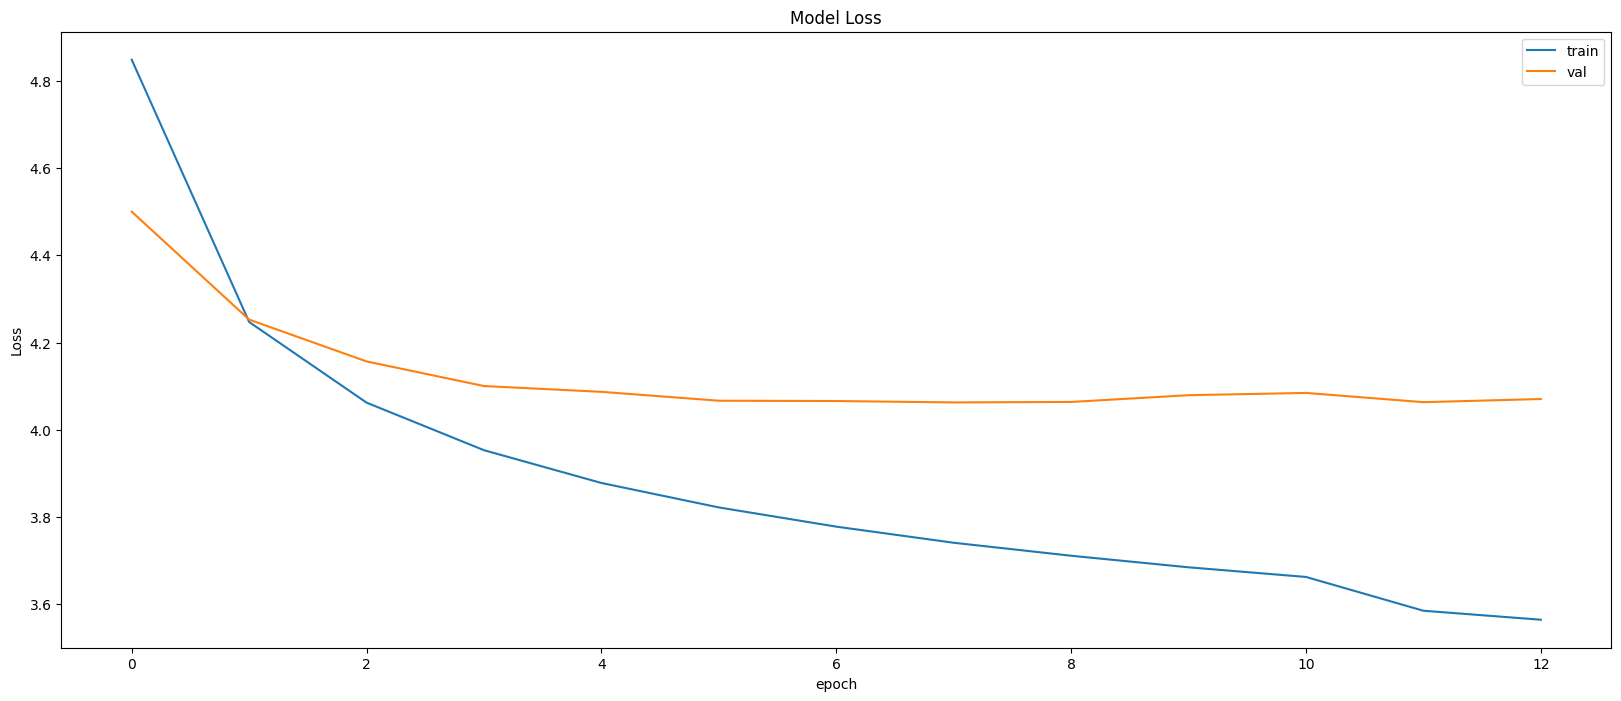

In [19]:
plt.figure(figsize=(20,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

In [25]:
pickle.dump(tokenizer, open("tokenizer.pkl",'wb'))
pickle.dump(fe, open("feature_extractor.pkl",'wb'))

In [51]:
model_path = "Y:/Projects/Caption Generation/Models/model.keras"
tokenizer_path = "Y:/Projects/Caption Generation/Models/tokenizer.pkl"
feature_extractor_path = "Y:/Projects/Caption Generation/Models/feature_extractor.keras"

def CaptionGen(image_path, model_path, tokenizer_path, feature_extractor_path, max_length=74, img_size=224):
    caption_model = load_model(model_path)
    feature_extractor = load_model(feature_extractor_path)
    tokenizer = tokenizer = pickle.load(open("tokenizer.pkl", "rb"))

    img = load_img(image_path, target_size=(img_size,img_size))
    img = img_to_array(img) / 255.0
    img = np.expand_dims(img,axis=0)
    image_features = feature_extractor.predict(img, verbose=0)

    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences({in_text})[0]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = caption_model.predict([image_features, sequence], verbose=0)
        yhat_index = np.argmax(yhat)
        word = tokenizer.index_word.get(yhat_index, None)
        if word is None:
            break
        in_text += " "+ word
        if word == 'endseq':
            break
    caption = in_text.replace("startseq",' ').replace("endseq",' ').strip()
    img = load_img(image_path, target_size=(255,255))
    plt.figure(figsize=(8,8))
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=16, color='blue')
    plt.show()